<a href="https://colab.research.google.com/github/aminaakm/amina/blob/main/CART_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

uploaded = files.upload()

Saving cart_py_data.csv to cart_py_data.csv


In [2]:
import pandas as pd
import numpy as np

# Load the data into a pandas DataFrame
df = pd.read_csv('cart_py_data.csv')

# Replace '#VALUE!' with NaN in the relevant columns
for col in ['bmi', 'WC', 'HC', 'WHR']:
    df[col] = df[col].replace('#VALUE!', np.nan)

# Create the binary outcome variable 'increased_bp'
# The code (df['sbp_avg'] >= 140) returns True/False.
# .astype(int) converts True to 1 and False to 0.
df['increased_bp'] = (df['sbp_avg'] >= 140).astype(int)

# Check the distribution of the new outcome variable
# This tells us how many people are in each category.
print("Distribution of the outcome variable:")
print(df['increased_bp'].value_counts())

# Display the dataframe with the new column
df.head()

/tmp/ipython-input-3945554604.py:5: DtypeWarning: Columns (0,2,4,5,6,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cart_py_data.csv')


Distribution of the outcome variable:
increased_bp
0    687772
1     36343
Name: count, dtype: int64


,caseid,sbp_avg,sex,age,height,weight,bmi,WC,HC,WHR,increased_bp
0,0100101305 04,123.333333,male,22.0,142.7,35.3,17.33511628,101.4,115.9,0.874892148403796,0
1,0100101305 05,118.000000,male,19.0,139.7,31,15.88432929,97.3,112.6,0.864120781527531,0
2,0100101345 02,114.333333,male,38.0,147.9,75.5,34.51521664,121.7,128.6,0.946345256609642,0
3,0100101383 02,119.333333,male,40.0,162.7,70.8,26.7459576,109.3,120.7,0.905550952775476,0
4,0100101383 03,121.333333,male,22.0,152.7,35.8,15.35341371,109.0,100,1.09,0


In [3]:
from sklearn.model_selection import train_test_split
import numpy as np

# Define your predictor variables (X) and the target variable (y)
# These are the measurements the model will use to make predictions.
predictors = ['bmi', 'WC', 'HC', 'WHR']
target = 'increased_bp'

X = df[predictors]
y = df[target]

# Drop rows with NaN values in the predictor columns
X = X.dropna()
y = y[X.index] # Ensure y aligns with the dropped rows in X

# Split the data: 70% for training, 30% for testing
# random_state=42 ensures that the split is the same every time you run the code.
# stratify=y ensures the training and testing sets have a similar proportion of
# people with and without increased blood pressure.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set has {X_train.shape[0]} samples.")
print(f"Testing set has {X_test.shape[0]} samples.")

Training set has 441815 samples.
Testing set has 189350 samples.


In [4]:
# Import the necessary functions from scikit-learn
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
import numpy as np

# Initialize and train the classification tree model
# max_depth=4 keeps the tree from getting too complex and makes it easier to interpret.
cart_model = DecisionTreeClassifier(random_state=42, max_depth=4)
cart_model.fit(X_train, y_train)

# --- Evaluate on the TRAINING Set ---
print("--- Training Set Evaluation ---")

y_train_pred = cart_model.predict(X_train)
y_train_proba = cart_model.predict_proba(X_train)

# 1. Misclassification Error Rate
misclassification_train = 1 - accuracy_score(y_train, y_train_pred)
print(f"Misclassification Rate: {misclassification_train:.3f}")

# 2. Deviance (Cross-Entropy Loss)
deviance_train = log_loss(y_train, y_train_proba, normalize=False)
print(f"Deviance: {deviance_train:.2f}")

# 3. Pseudo R-squared
# This compares our model's deviance to a basic model that just guesses the average.
null_proba = np.full_like(y_train_proba, y_train.mean())
null_deviance = log_loss(y_train, null_proba, normalize=False)
pseudo_r2 = 1 - (deviance_train / null_deviance)
print(f"Pseudo R-squared: {pseudo_r2:.3f}")

# --- Evaluate on the TEST Set (Cross-Validation) ---
print("\n--- Test Set Evaluation ---")
y_test_pred = cart_model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

# Sensitivity (how well it finds positives) and Specificity (how well it finds negatives)
sensitivity_test = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity_test = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"Sensitivity: {sensitivity_test:.2%}")
print(f"Specificity: {specificity_test:.2%}")

--- Training Set Evaluation ---
Misclassification Rate: 0.056
Deviance: 91048.33
Pseudo R-squared: 0.928

--- Test Set Evaluation ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Sensitivity: 0.00%
Specificity: 100.00%


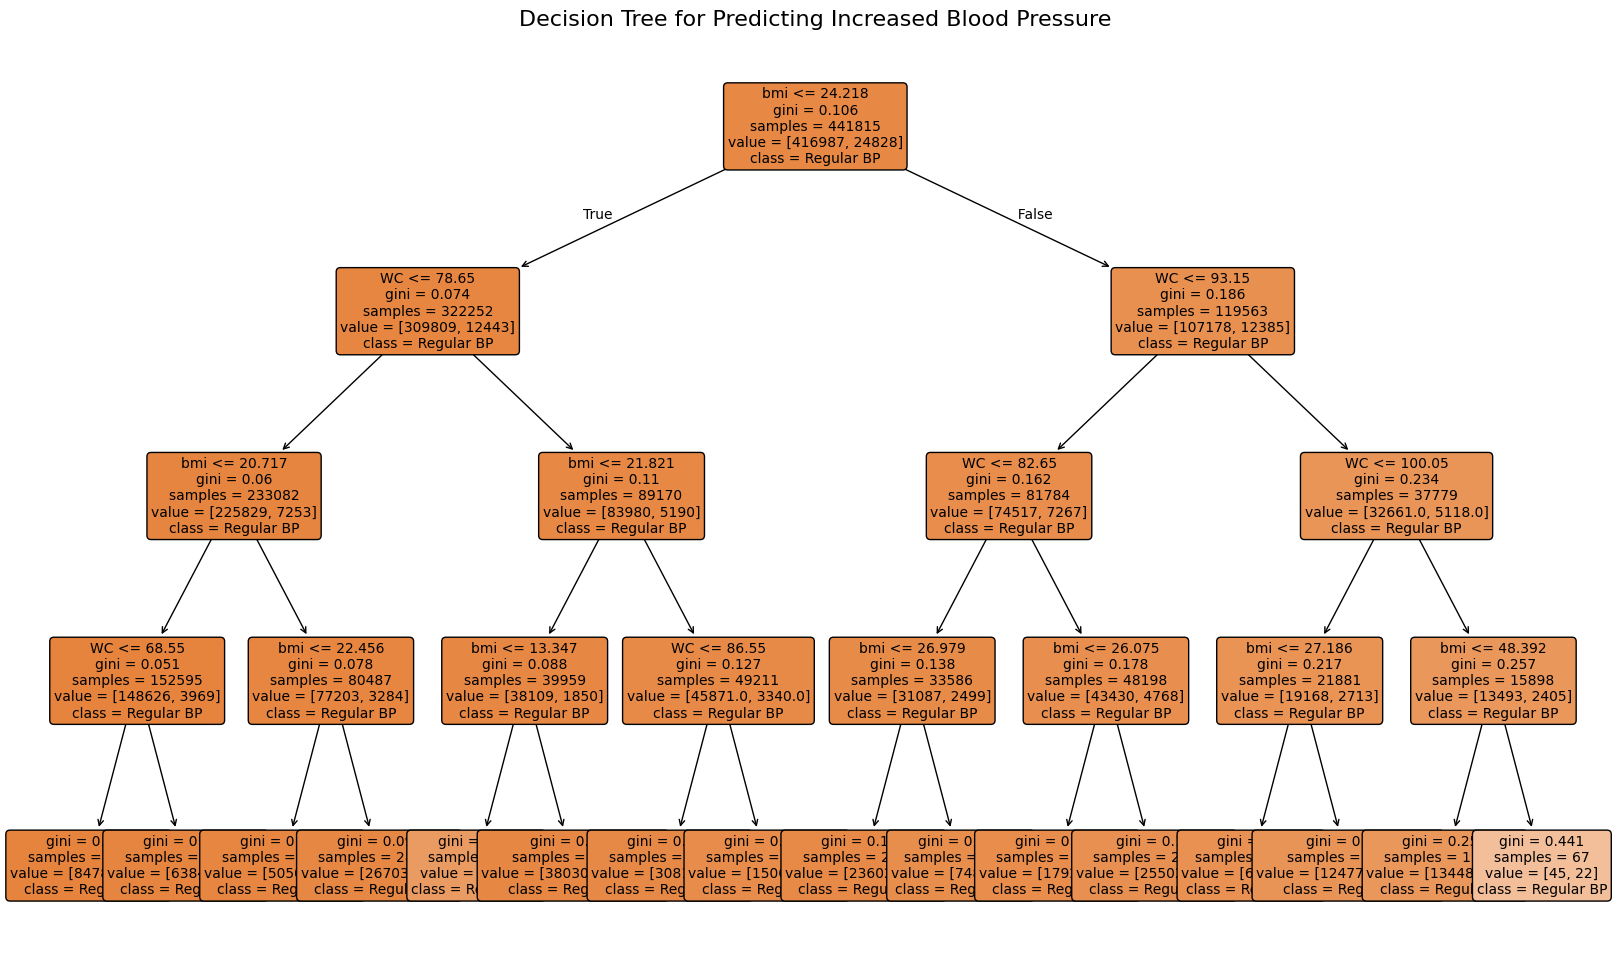

In [5]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Set the figure size for better readability
plt.figure(figsize=(20, 12))

# Create the plot
plot_tree(cart_model,
          feature_names=predictors,
          class_names=['Regular BP', 'Increased BP'], # Names for 0 and 1
          filled=True,  # Color the nodes
          rounded=True, # Use rounded boxes
          fontsize=10)

# Add a title and display the plot
plt.title("Decision Tree for Predicting Increased Blood Pressure", fontsize=16)
plt.show()

This decision tree visualizes the model's decision-making process for predicting increased blood pressure based on the input features (BMI, WC, HC, and WHR).

Here's a breakdown of how to interpret it:

Nodes: Each box in the tree is a node. The top node is the root node, representing the entire dataset. Internal nodes (the boxes in the middle) represent a decision rule based on one of the features (e.g., bmi <= 24.218). They have branches leading to other nodes. Leaf nodes (the boxes at the bottom) represent the final prediction (the class). Branches: The lines connecting the nodes represent the outcomes of the decision rule in the parent node (True or False). Information within each node: The first line shows the decision rule (only in internal nodes). gini is the Gini impurity, a measure of how mixed the classes are within that node. A gini of 0 means all samples in that node belong to the same class. samples is the number of samples in that node. value shows the distribution of classes in that node. For example, [416981, 249828] means there are 416981 samples of class 0 ('Regular BP') and 249828 samples of class 1 ('Increased BP'). class indicates the predicted class for the majority of samples in that node. Essentially, you start at the root node and follow the branches based on the decision rules that apply to a given data sample until you reach a leaf node, which provides the predicted class. This tree helps understand which features and thresholds are most important in classifying individuals as having or not having increased blood pressure according to this model.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Initialize and train the logistic regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Calculate the AUC score on the test set
# AUC measures how well the model can distinguish between the two classes.
# A score of 1.0 is perfect; 0.5 is no better than random guessing.
auc_score = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])

print(f"\n--- Logistic Regression Comparison ---")
print(f"Logistic Regression AUC on Test Set: {auc_score:.3f}")


--- Logistic Regression Comparison ---
Logistic Regression AUC on Test Set: 0.667
